<a href="https://colab.research.google.com/github/mahshadmoradi/Machine-Learning/blob/main/Q3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 align="center">Introduction to Machine Learning - Course Code: 25737</h1>
<h4 align="center">Instructor: Dr. Amiri</h4>
<h4 align="center">Sharif University of Technology, Spring 2024</h4>
<h4 align="center">Computer Assignment 3</h4>
<h4 align="center">

Question 3

</h4>

# Personal Data

In [ ]:
# Set your student number
student_number = 400109373
Name = 'Mahshad'
Last_Name = 'Moradi'

# Autoencoders (25 Points)

In this problem, you should implement an autoencoder network, which generates an image presenting the next digit of the input digit. Here are some examples:

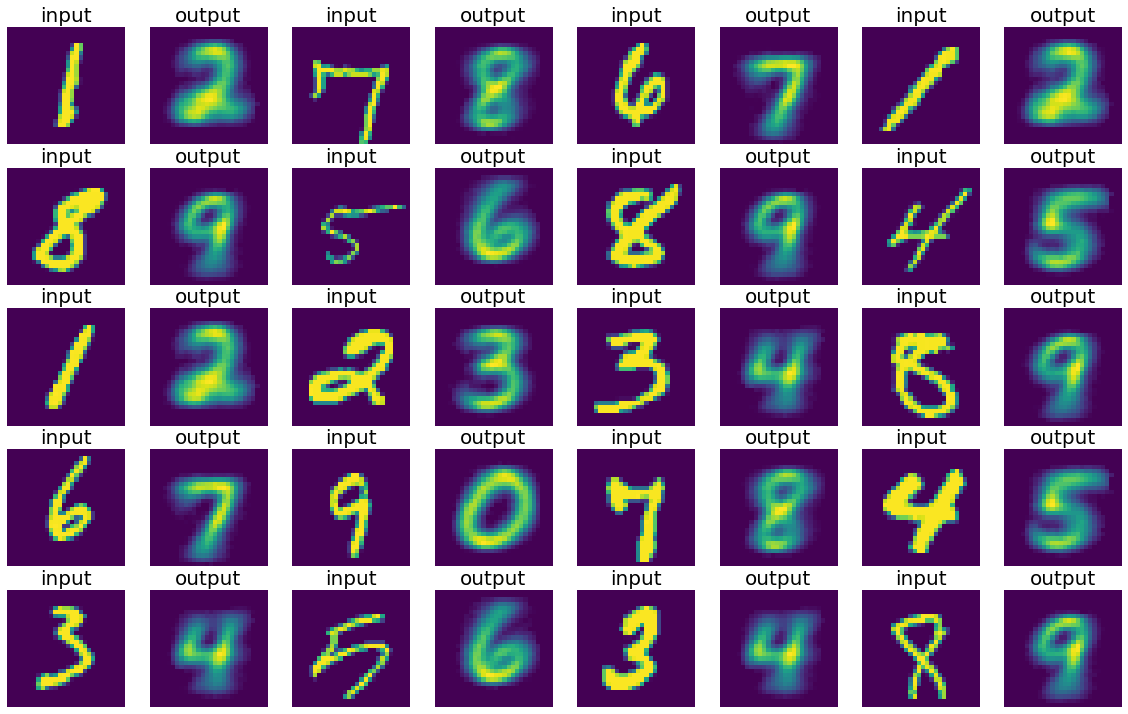

You should use the MNIST dataset, and the ground-truth for each example is provided by a helper function. Make sure to put the `ae_helper.py` file next to this notebook to use the helper function.

## Get the data

Get the data and split them into training, validation, and test sets, by running the following cell. `X` is the input images, `Y` is the ground-truth for each input, and `y` is the input's label.

In [36]:
from ae_helper import get_data
from sklearn.model_selection import train_test_split

X, Y, y = get_data()

X_train, X_test, Y_train, Y_test, y_train, y_test = train_test_split(X, Y, y, test_size=0.2, random_state=17)
X_train, X_val, Y_train, Y_val, y_train, y_val = train_test_split(X_train, Y_train, y_train, test_size=0.1, random_state=17)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


## Design your model

Please Implement your autoencoder model below. You MUST implement your model using the `torch` package. The model should input a batch of images and output the generated images for the whole batch. Your model can be consist of fully connected layers (using linear layers), but using fully-convolutional models has extra points.

In [37]:
#### IMPLEMENT YOUR MODEL ####
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.nn import functional as F

class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        # your code here
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),  # [b, 16, 14, 14]
            nn.ReLU(True),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # [b, 32, 7, 7]
            nn.ReLU(True),
            nn.Conv2d(32, 64, kernel_size=7)  # [b, 64, 1, 1]
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=7),  # [b, 32, 7, 7]
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # [b, 16, 14, 14]
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # [b, 1, 28, 28]
            nn.Sigmoid()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # your code here
        x = self.encoder(x)
        x = self.decoder(x)
        return x


## The dataset class, and the dataloaders

The following cells implement the dataset class and create the data loaders for training and validation sets. Feel free to modify the batch size for each data loader.

In [38]:
from typing import Tuple
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

class MnistNextDigitDataset(Dataset):
    def __init__(self, X: np.ndarray, Y: np.ndarray, y: np.ndarray):
        self.X = torch.from_numpy(X)
        self.Y = torch.from_numpy(Y)
        self.y = torch.from_numpy(y)

    def __len__(self) -> int:
        return self.X.shape[0]

    def __getitem__(self, i: int) -> Tuple[torch.Tensor, ...]:
        return self.X[i], self.Y[i], self.y[i]

In [39]:
train_dataloader = DataLoader(
    MnistNextDigitDataset(X_train, Y_train, y_train),
    batch_size=512,
    shuffle=True
)
val_dataloader = DataLoader(
    MnistNextDigitDataset(X_val, Y_val, y_val),
    batch_size=1024,
    shuffle=False
)

In [40]:
# place for your custom functions for training and evaluation of the autoencoder

device = 'cuda' if torch.cuda.is_available() else 'cpu'

def train_autoencoder(model: nn.Module, optimizer: torch.optim.Optimizer, dataloader: DataLoader) -> float:

    # your code here
    model.train()
    epoch_loss = 0
    for X, Y, y in dataloader:
        X = X.unsqueeze(1).to(device)  # Add channel dimension and move to device
        Y = Y.unsqueeze(1).to(device)  # Add channel dimension and move to device
        optimizer.zero_grad()
        output = model(X)
        loss = F.mse_loss(output, Y)  # Compare output to Y (next digit image)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    epoch_loss /= len(dataloader)
    return epoch_loss


def eval_autoencoder(model: nn.Module, dataloader: DataLoader) -> float:

    # your code here
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for X, Y, y in dataloader:
            X = X.unsqueeze(1).to(device)  # Add channel dimension and move to device
            Y = Y.unsqueeze(1).to(device)  # Add channel dimension and move to device
            output = model(X)
            loss = F.mse_loss(output, Y)  # Compare output to Y (next digit image)
            epoch_loss += loss.item()
    epoch_loss /= len(dataloader)
    return epoch_loss

## Instantiate the model and optimizer

Instantiate your model and optimizer in the following cell. Feel free to choose the optimizer and its configurations such as learning rate, decay, etc.

In [41]:
#### INSTANTIATE YOUR MODEL AND OPTIMIZER ####
ae = AutoEncoder().to(device=device)
optimizer = torch.optim.Adam(ae.parameters(), lr=1e-3) #...

## Train your autoencoder

Write your training/validation loop in the following cell for an arbitrary number of epochs (until convergence is detected). Make sure to use proper and readable logging containing training and validation metrics for each epoch. Select and store the state dictionary of the best epoch model according to the metrics.

In [42]:
#### IMPLEMENT YOUR TRAIN/VAL LOOP ####

num_epochs = 20
best_val_loss = float('inf')
best_model_state = None

# Training and validation loop
for epoch in range(num_epochs):
    train_loss = train_autoencoder(ae, optimizer, train_dataloader)
    val_loss = eval_autoencoder(ae, val_dataloader)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    # Save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = ae.state_dict()


Epoch 1/20, Train Loss: 0.0975, Val Loss: 0.0688
Epoch 2/20, Train Loss: 0.0680, Val Loss: 0.0674
Epoch 3/20, Train Loss: 0.0668, Val Loss: 0.0658
Epoch 4/20, Train Loss: 0.0635, Val Loss: 0.0619
Epoch 5/20, Train Loss: 0.0605, Val Loss: 0.0597
Epoch 6/20, Train Loss: 0.0588, Val Loss: 0.0583
Epoch 7/20, Train Loss: 0.0578, Val Loss: 0.0575
Epoch 8/20, Train Loss: 0.0572, Val Loss: 0.0570
Epoch 9/20, Train Loss: 0.0568, Val Loss: 0.0569
Epoch 10/20, Train Loss: 0.0565, Val Loss: 0.0565
Epoch 11/20, Train Loss: 0.0563, Val Loss: 0.0563
Epoch 12/20, Train Loss: 0.0561, Val Loss: 0.0561
Epoch 13/20, Train Loss: 0.0560, Val Loss: 0.0560
Epoch 14/20, Train Loss: 0.0558, Val Loss: 0.0558
Epoch 15/20, Train Loss: 0.0557, Val Loss: 0.0557
Epoch 16/20, Train Loss: 0.0556, Val Loss: 0.0556
Epoch 17/20, Train Loss: 0.0555, Val Loss: 0.0555
Epoch 18/20, Train Loss: 0.0554, Val Loss: 0.0556
Epoch 19/20, Train Loss: 0.0553, Val Loss: 0.0554
Epoch 20/20, Train Loss: 0.0553, Val Loss: 0.0554


## Load the state dictionary of the best epoch

Load the state dictionary of the best epoch model into the model object.

In [43]:
#### LOAD THE BEST EPOCH STATE DICTIONARY ####

# Load the best model state
ae.load_state_dict(best_model_state)

# Save the best model
torch.save(best_model_state, 'best_autoencoder_model.pth')

## Visualize your model

Select 40 examples from the test set and visualize the input and output of the model for them (See the examples at the beginning of the notebook).

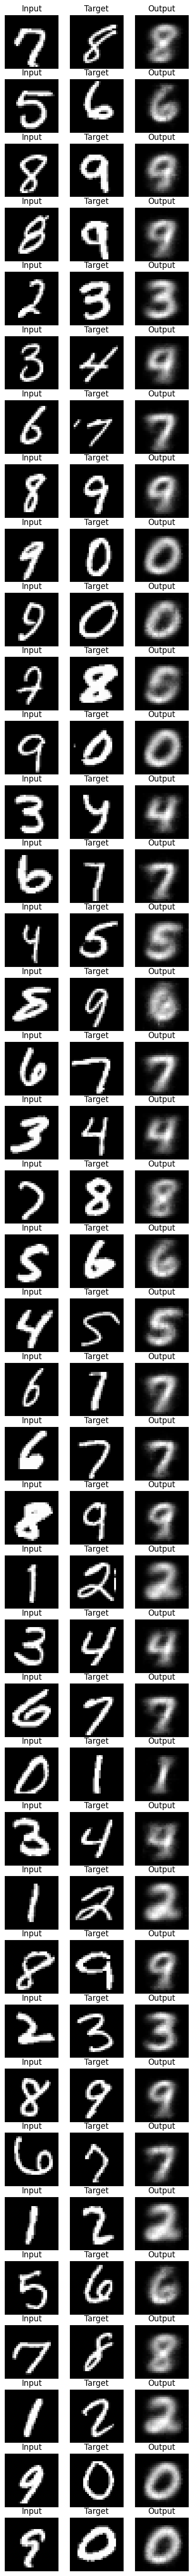

In [75]:
#### VISUALIZE YOUR MODEL ####
import matplotlib.pyplot as plt

def visualize_model(model: nn.Module, dataloader: DataLoader, num_examples: int = 40):
    model.eval()
    examples = []

    with torch.no_grad():
        for X, Y, y in dataloader:
            X = X.unsqueeze(1).to(device)  # Add channel dimension and move to device
            Y = Y.unsqueeze(1).to(device)  # Add channel dimension and move to device
            output = model(X)
            X = X.cpu()
            Y = Y.cpu()
            output = output.cpu()
            examples.append((X, Y, output))
            if len(examples) * X.size(0) >= num_examples:
                break

    # Flatten the list of examples and take the required number
    examples = [(x, y, z) for batch in examples for x, y, z in zip(batch[0], batch[1], batch[2])]
    examples = examples[:num_examples]

    # Plot the results
    fig, axes = plt.subplots(nrows=num_examples, ncols=3, figsize=(5, 70))
    for i, (input_img, target_img, output_img) in enumerate(examples):
        input_img = input_img.squeeze(0)  # Remove the channel dimension
        target_img = target_img.squeeze(0)  # Remove the channel dimension
        output_img = output_img.squeeze(0)  # Remove the channel dimension

        axes[i, 0].imshow(input_img, cmap='gray')
        axes[i, 0].axis('off')
        axes[i, 0].set_title('Input')

        axes[i, 1].imshow(target_img, cmap='gray')
        axes[i, 1].axis('off')
        axes[i, 1].set_title('Target')

        axes[i, 2].imshow(output_img, cmap='gray')
        axes[i, 2].axis('off')
        axes[i, 2].set_title('Output')

    plt.show()

# Visualize 40 examples from the validation set
visualize_model(ae, val_dataloader, num_examples=40)

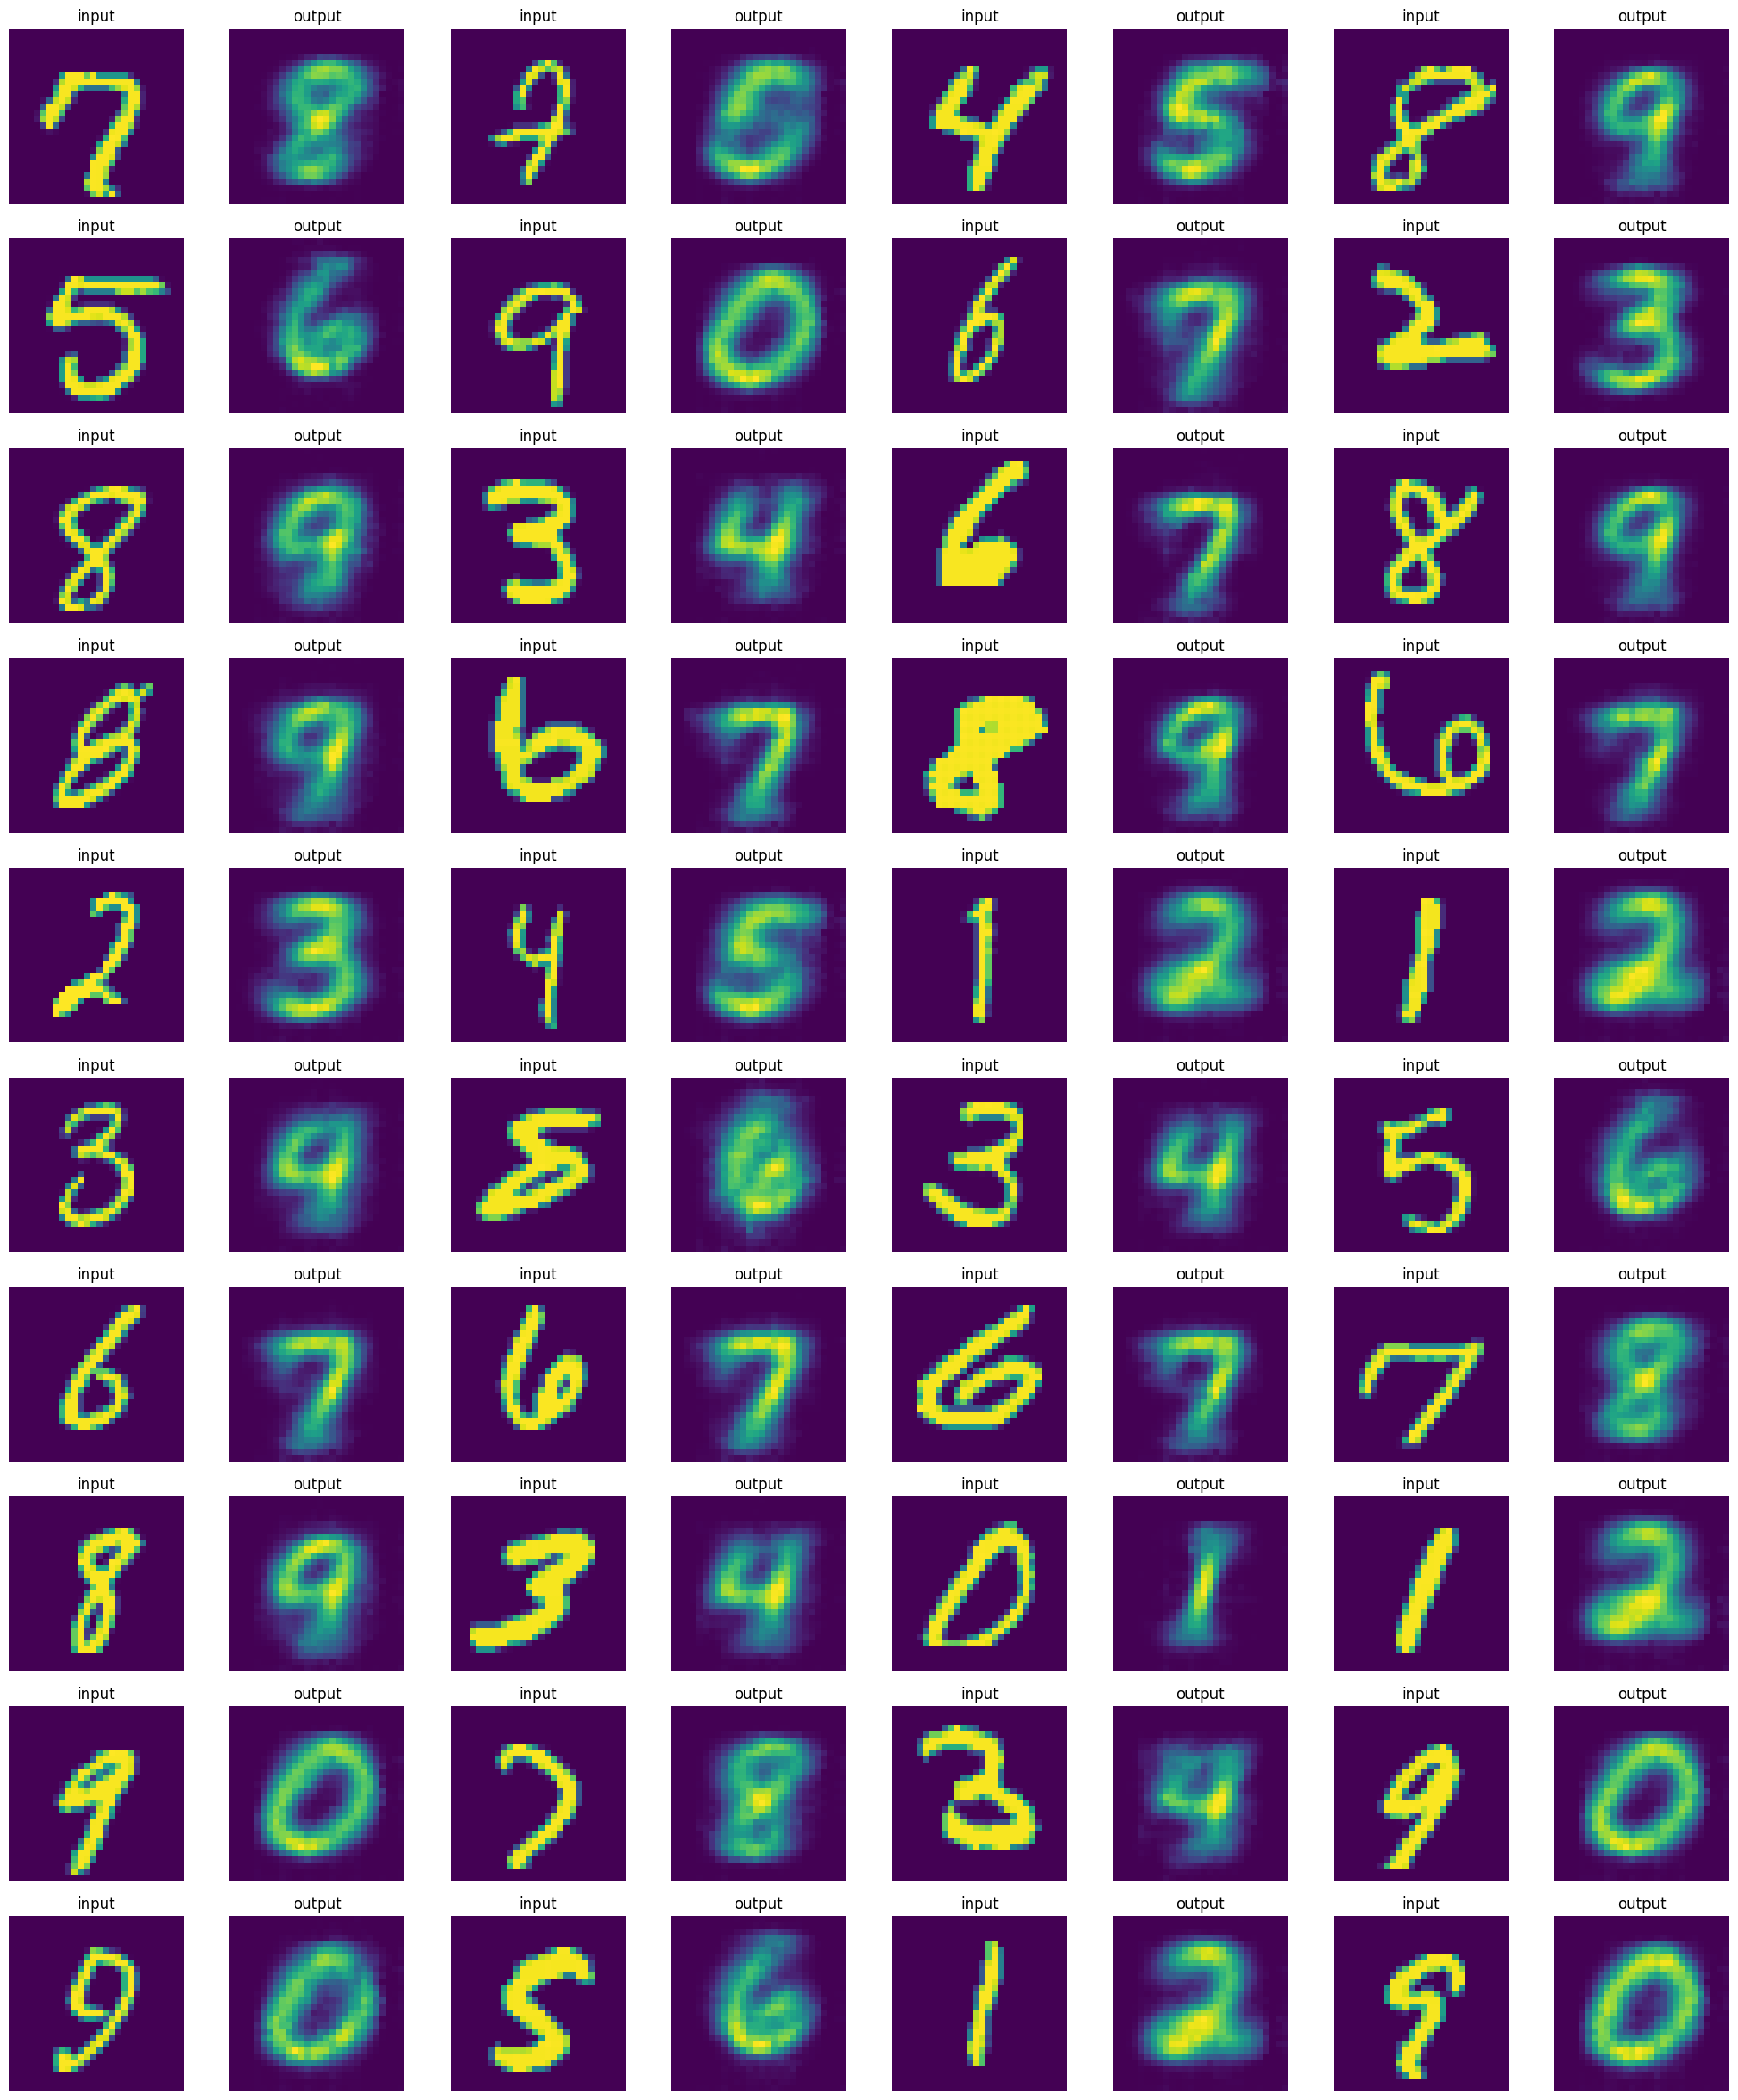

In [88]:
import matplotlib.pyplot as plt

def visualize_model(model: nn.Module, dataloader: DataLoader, num_examples: int = 40):
    model.eval()
    examples = []

    with torch.no_grad():
        for X, Y, y in dataloader:
            X = X.unsqueeze(1).to(device)  # Add channel dimension and move to device
            output = model(X)
            X = X.cpu()
            output = output.cpu()
            examples.append((X, output))
            if len(examples) * X.size(0) >= num_examples:
                break

    # Flatten the list of examples and take the required number
    examples = [(x, y) for batch in examples for x, y in zip(batch[0], batch[1])]
    examples = examples[:num_examples]


    # Plot the results
    fig, axes = plt.subplots(nrows=10, ncols=8, figsize=(25, 30))
    for i, (input_img, output_img) in enumerate(examples):
        input_img = input_img.squeeze(0)  # Remove the channel dimension
        output_img = output_img.squeeze(0)  # Remove the channel dimension

        c = (i//10) *2
        r = i%10

        axes[r, c].imshow(input_img, cmap='viridis')
        axes[r, c].axis('off')
        axes[r, c].set_title('input')

        axes[r, c+1].imshow(output_img, cmap='viridis')
        axes[r, c+1].axis('off')
        axes[r, c+1].set_title('output')

    plt.show()

# Visualize 40 examples from the validation set
visualize_model(ae, val_dataloader, num_examples=40)
